[04/07/25 13:08:34] INFO     Found credentials from IAM Role:                                   ]8;id=993650;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=866538;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Loaded dataset with shape: (35000, 13)
Best params for xgb_demand.joblib: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

Demand Forecasting Evaluation Metrics:
MAE: 0.0191
MSE: 0.0009
RMSE: 0.0302
R2: 0.9952


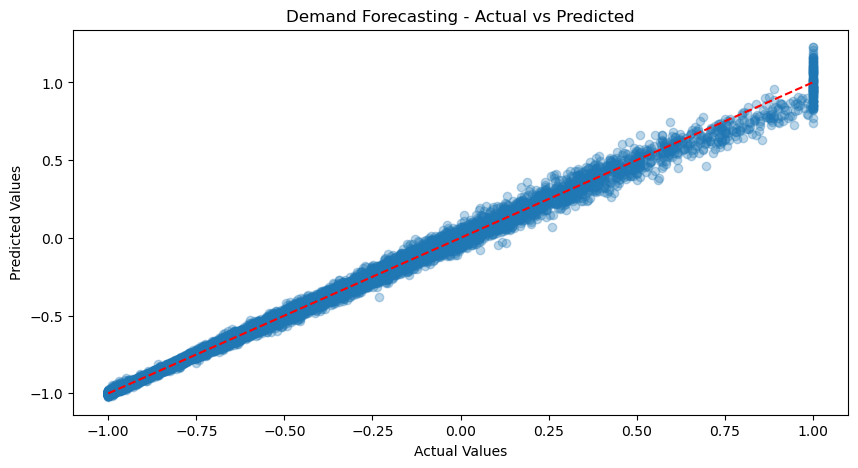

Best params for xgb_price.joblib: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

Price Optimization Evaluation Metrics:
MAE: 0.0578
MSE: 0.0046
RMSE: 0.0681
R2: 0.9859


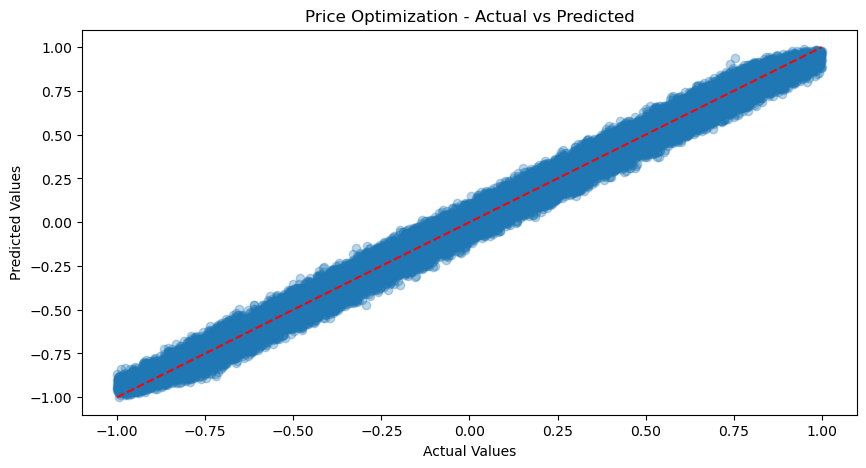

Saved dashboard_ready_input.csv


In [11]:
# Imports
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# SageMaker session 
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
prefix = 'xgboost-models'

# Load Data
def load_data():
    data = pd.read_csv("demand_forecasting_data.csv")
    print(f"Loaded dataset with shape: {data.shape}")
    return data

# Capping 
def cap_outliers(df, col, lower_q=0.01, upper_q=0.99):
    low_cap = df[col].quantile(lower_q)
    high_cap = df[col].quantile(upper_q)
    df[col] = np.clip(df[col], low_cap, high_cap)
    return df

# Encoders
def save_label_encoders(df, cols, save_dir="encoders/"):
    os.makedirs(save_dir, exist_ok=True)
    for col in cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        joblib.dump(le, f"{save_dir}/label_encoder_{col}.joblib")
    return df
    
# Scalers
def save_scalers(X, y, target_name, save_dir="scalers/"):
    os.makedirs(save_dir, exist_ok=True)
    X_scaler = MinMaxScaler(feature_range=(-1, 1))
    y_scaler = MinMaxScaler(feature_range=(-1, 1))
    X_scaled = X_scaler.fit_transform(X)
    y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()
    joblib.dump(X_scaler, f"{save_dir}/scaler_X_{target_name}.joblib")
    joblib.dump(y_scaler, f"{save_dir}/scaler_y_{target_name}.joblib")
    return X_scaled, y_scaled, X_scaler, y_scaler

# Preprocessing 
# Preprocessing 
def preprocess(df):
    df.columns = df.columns.str.strip()
    df.dropna(inplace=True)
    df["Date"] = pd.to_datetime(df["Date"])
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    df["Weekday"] = df["Date"].dt.weekday
    df.drop(columns=["Date"], inplace=True)
    df = cap_outliers(df, "Demand")
    # Label encoding for categorical columns
    df = save_label_encoders(df, ["Product_ID", "Marketing_Campaign", "Seasonal_Trend"])  
    # Binary encode Public_Holiday
    df["Public_Holiday"] = df["Public_Holiday"].astype(int)
    
    return df


# XGB Model Training
def train_model(X, y, model_name):
    params = {
        "n_estimators": [100, 200],
        "max_depth": [3, 6],
        "learning_rate": [0.01, 0.1],
    }
    model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    grid = GridSearchCV(model, params, cv=3, scoring="neg_mean_absolute_error")
    grid.fit(X, y)
    print(f"Best params for {model_name}: {grid.best_params_}")
    joblib.dump(grid.best_estimator_, model_name)
    return grid.best_estimator_

# Evaluation
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }
    print(f"\n{model_name} Evaluation Metrics:")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{model_name} - Actual vs Predicted")
    plt.show()
    return metrics

# MAIN
if __name__ == "__main__":
    df = load_data()
    df = preprocess(df)

    features = [
        "Year", "Month", "Day", "Weekday", "Product_ID",
        "Marketing_Campaign", "Seasonal_Trend", "Stock_Availability",
        "Base_Sales", "Marketing_Effect", "Seasonal_Effect",
        "Discount", "Competitor_Price", "Public_Holiday"
    ]

    df = df.sort_values(by=["Year", "Month", "Day"]).reset_index(drop=True)
    train_data = df[df["Year"] < 2021]
    test_data = df[df["Year"] == 2021]

    # DEMAND MODEL
    X_train_demand = train_data[features + ["Price"]]
    y_train_demand = train_data["Demand"]
    X_test_demand = test_data[features + ["Price"]]
    y_test_demand = test_data["Demand"]
    X_scaled_demand, y_scaled_demand, x_scaler_demand, y_scaler_demand = save_scalers(X_train_demand, y_train_demand, "demand")
    xgb_demand = train_model(X_scaled_demand, y_scaled_demand, "xgb_demand.joblib")
    X_test_demand_scaled = x_scaler_demand.transform(X_test_demand)
    y_test_demand_scaled = y_scaler_demand.transform(y_test_demand.values.reshape(-1, 1)).flatten()
    evaluate_model(xgb_demand, X_test_demand_scaled, y_test_demand_scaled, "Demand Forecasting")

    # PRICE MODEL
    X_train_price = train_data[features + ["Demand"]]
    y_train_price = train_data["Price"]
    X_test_price = test_data[features + ["Demand"]]
    y_test_price = test_data["Price"]
    X_scaled_price, y_scaled_price, x_scaler_price, y_scaler_price = save_scalers(X_train_price, y_train_price, "price")
    xgb_price = train_model(X_scaled_price, y_scaled_price, "xgb_price.joblib")
    X_test_price_scaled = x_scaler_price.transform(X_test_price)
    y_test_price_scaled = y_scaler_price.transform(y_test_price.values.reshape(-1, 1)).flatten()
    evaluate_model(xgb_price, X_test_price_scaled, y_test_price_scaled, "Price Optimization")

    # Save dashboard input
    dashboard_ready = df[features + ["Price", "Demand"]]
    dashboard_ready.to_csv("dashboard_ready_input.csv", index=False)
    print("Saved dashboard_ready_input.csv")


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[04/07/25 19:39:19] INFO     Found credentials from IAM Role:                                   ]8;id=265473;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=587398;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[04/07/25 19:39:20] INFO     Found credentials from IAM Role:                                   ]8;id=252560;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=376823;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Loaded dataset with shape: (35000, 13)
Best params for xgb_demand.joblib: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

Demand Forecasting Evaluation Metrics:
MAE: 0.0191
MSE: 0.0009
RMSE: 0.0302
R2: 0.9952


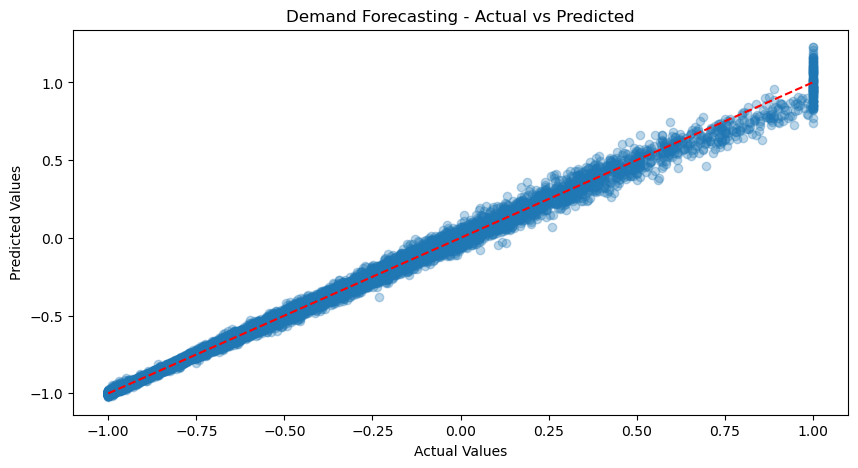

Best params for xgb_price.joblib: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

Price Optimization Evaluation Metrics:
MAE: 0.0578
MSE: 0.0046
RMSE: 0.0681
R2: 0.9859


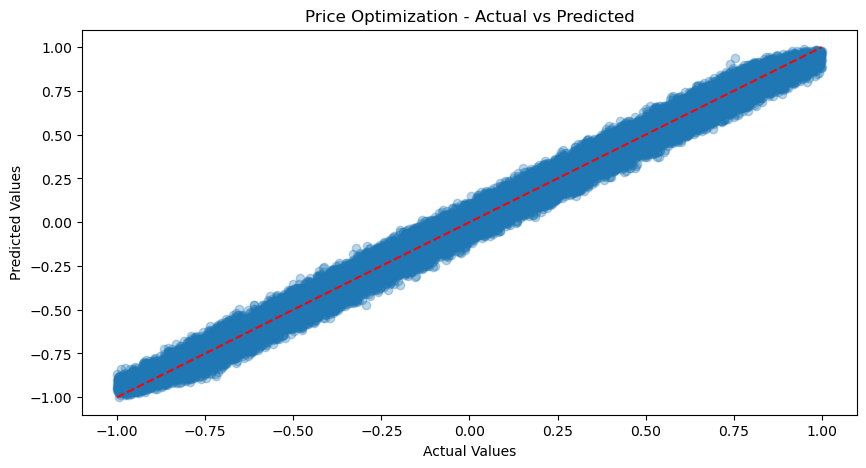

Saved dashboard_ready_input.csv


In [4]:
# Imports
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# SageMaker session 
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
prefix = 'xgboost-models'

# Load Data
def load_data():
    data = pd.read_csv("demand_forecasting_data.csv")
    print(f"Loaded dataset with shape: {data.shape}")
    return data

# Capping 
def cap_outliers(df, col, lower_q=0.01, upper_q=0.99):
    low_cap = df[col].quantile(lower_q)
    high_cap = df[col].quantile(upper_q)
    df[col] = np.clip(df[col], low_cap, high_cap)
    return df

# Encoders
def save_label_encoders(df, cols, save_dir="encoders/"):
    os.makedirs(save_dir, exist_ok=True)
    for col in cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        joblib.dump(le, f"{save_dir}/label_encoder_{col}.joblib")
    return df
    
# Scalers
def save_scalers(X, y, target_name, save_dir="scalers/"):
    os.makedirs(save_dir, exist_ok=True)
    X_scaler = MinMaxScaler(feature_range=(-1, 1))
    y_scaler = MinMaxScaler(feature_range=(-1, 1))
    X_scaled = X_scaler.fit_transform(X)
    y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()
    joblib.dump(X_scaler, f"{save_dir}/scaler_X_{target_name}.joblib")
    joblib.dump(y_scaler, f"{save_dir}/scaler_y_{target_name}.joblib")
    return X_scaled, y_scaled, X_scaler, y_scaler

# Preprocessing 
# Preprocessing 
def preprocess(df):
    df.columns = df.columns.str.strip()
    df.dropna(inplace=True)
    df["Date"] = pd.to_datetime(df["Date"])
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    df["Weekday"] = df["Date"].dt.weekday
    df.drop(columns=["Date"], inplace=True)
    df = cap_outliers(df, "Demand")
    # Label encoding for categorical columns
    df = save_label_encoders(df, ["Product_ID", "Marketing_Campaign", "Seasonal_Trend"])  
    # Binary encode Public_Holiday
    df["Public_Holiday"] = df["Public_Holiday"].astype(int)
    
    return df


#Model Training
def train_model(X, y, model_name):
    params = {
        "n_estimators": [100, 200],
        "max_depth": [3, 6],
        "learning_rate": [0.01, 0.1],
    }
    model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    grid = GridSearchCV(model, params, cv=3, scoring="neg_mean_absolute_error")
    grid.fit(X, y)
    print(f"Best params for {model_name}: {grid.best_params_}")
    joblib.dump(grid.best_estimator_, model_name)
    return grid.best_estimator_

# Evaluation
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }
    print(f"\n{model_name} Evaluation Metrics:")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{model_name} - Actual vs Predicted")
    plt.show()
    return metrics

# MAIN
if __name__ == "__main__":
    df = load_data()
    df = preprocess(df)

    features = [
        "Year", "Month", "Day", "Weekday", "Product_ID",
        "Marketing_Campaign", "Seasonal_Trend", "Stock_Availability",
        "Base_Sales", "Marketing_Effect", "Seasonal_Effect",
        "Discount", "Competitor_Price", "Public_Holiday"
    ]

    df = df.sort_values(by=["Year", "Month", "Day"]).reset_index(drop=True)
    train_data = df[df["Year"] < 2021]
    test_data = df[df["Year"] == 2021]

    # DEMAND MODEL
    X_train_demand = train_data[features + ["Price"]]
    y_train_demand = train_data["Demand"]
    X_test_demand = test_data[features + ["Price"]]
    y_test_demand = test_data["Demand"]
    X_scaled_demand, y_scaled_demand, x_scaler_demand, y_scaler_demand = save_scalers(X_train_demand, y_train_demand, "demand")
    xgb_demand = train_model(X_scaled_demand, y_scaled_demand, "xgb_demand.joblib")
    X_test_demand_scaled = x_scaler_demand.transform(X_test_demand)
    y_test_demand_scaled = y_scaler_demand.transform(y_test_demand.values.reshape(-1, 1)).flatten()
    evaluate_model(xgb_demand, X_test_demand_scaled, y_test_demand_scaled, "Demand Forecasting")

    # PRICE MODEL
    X_train_price = train_data[features + ["Demand"]]
    y_train_price = train_data["Price"]
    X_test_price = test_data[features + ["Demand"]]
    y_test_price = test_data["Price"]
    X_scaled_price, y_scaled_price, x_scaler_price, y_scaler_price = save_scalers(X_train_price, y_train_price, "price")
    xgb_price = train_model(X_scaled_price, y_scaled_price, "xgb_price.joblib")
    X_test_price_scaled = x_scaler_price.transform(X_test_price)
    y_test_price_scaled = y_scaler_price.transform(y_test_price.values.reshape(-1, 1)).flatten()
    evaluate_model(xgb_price, X_test_price_scaled, y_test_price_scaled, "Price Optimization")

    # Save dashboard input
    dashboard_ready = df[features + ["Price", "Demand"]]
    dashboard_ready.to_csv("dashboard_ready_input.csv", index=False)
    print("Saved dashboard_ready_input.csv")


In [5]:
# Save XGBoost Demand Predictions to CSV
# Re-predict on test data
y_pred_demand = xgb_demand.predict(X_test_demand_scaled)
y_pred_demand_inv = y_scaler_demand.inverse_transform(y_pred_demand.reshape(-1, 1)).flatten()

# Prepare DataFrame
df_xgb_demand_preds = pd.DataFrame({
    "Date": test_data[["Year", "Month", "Day"]].astype(str).agg("-".join, axis=1),
    "XGBoost_Predicted_Demand": y_pred_demand_inv
})

# Save to CSV
os.makedirs("model_output", exist_ok=True)
demand_output_path = os.path.join("model_output", "xgb_demand_predictions.csv")
df_xgb_demand_preds.to_csv(demand_output_path, index=False)
print(f"XGBoost demand predictions saved to {demand_output_path}")


XGBoost demand predictions saved to model_output/xgb_demand_predictions.csv


In [6]:
# Save XGBoost Price Predictions to CSV
y_pred_price = xgb_price.predict(X_test_price_scaled)
y_pred_price_inv = y_scaler_price.inverse_transform(y_pred_price.reshape(-1, 1)).flatten()

df_xgb_price_preds = pd.DataFrame({
    "Date": test_data[["Year", "Month", "Day"]].astype(str).agg("-".join, axis=1),
    "XGBoost_Predicted_Price": y_pred_price_inv
})

price_output_path = os.path.join("model_output", "xgb_price_predictions.csv")
df_xgb_price_preds.to_csv(price_output_path, index=False)
print(f"XGBoost price predictions saved to {price_output_path}")


XGBoost price predictions saved to model_output/xgb_price_predictions.csv


[04/08/25 16:25:05] INFO     Found credentials from IAM Role:                                   ]8;id=803182;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=12838;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Loaded dataset with shape: (35000, 13)
Best params for xgb_demand.joblib: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

Demand Forecasting Evaluation Metrics:
MAE: 0.0191
MSE: 0.0009
RMSE: 0.0302
R2: 0.9952


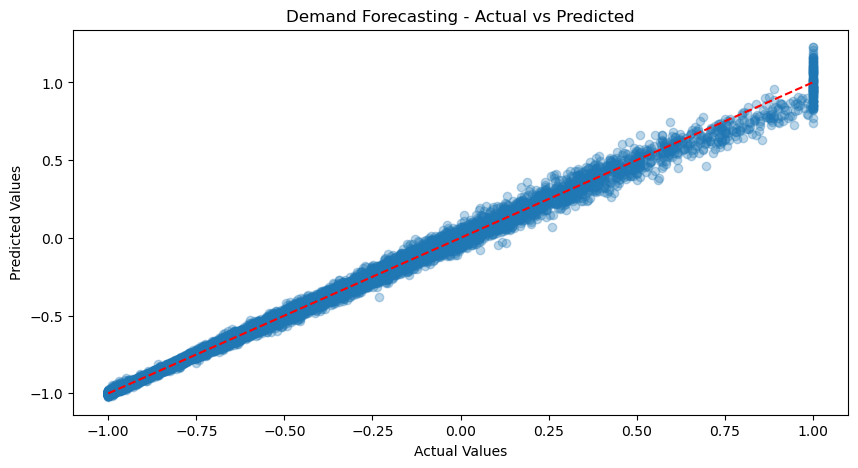

Best params for xgb_price.joblib: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

Price Optimization Evaluation Metrics:
MAE: 0.0578
MSE: 0.0046
RMSE: 0.0681
R2: 0.9859


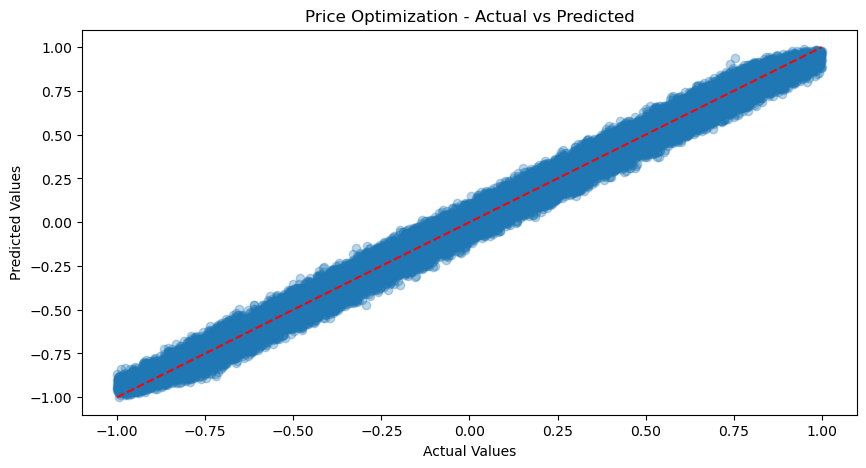

Saved dashboard_ready_input.csv for testing set only


In [4]:
# Imports
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# SageMaker session 
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
prefix = 'xgboost-models'

# Load Data
def load_data():
    data = pd.read_csv("demand_forecasting_data.csv")
    print(f"Loaded dataset with shape: {data.shape}")
    return data

# Capping 
def cap_outliers(df, col, lower_q=0.01, upper_q=0.99):
    low_cap = df[col].quantile(lower_q)
    high_cap = df[col].quantile(upper_q)
    df[col] = np.clip(df[col], low_cap, high_cap)
    return df

# Encoders
def save_label_encoders(df, cols, save_dir="encoders/"):
    os.makedirs(save_dir, exist_ok=True)
    for col in cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        joblib.dump(le, f"{save_dir}/label_encoder_{col}.joblib")
    return df
    
# Scalers
def save_scalers(X, y, target_name, save_dir="scalers/"):
    os.makedirs(save_dir, exist_ok=True)
    X_scaler = MinMaxScaler(feature_range=(-1, 1))
    y_scaler = MinMaxScaler(feature_range=(-1, 1))
    X_scaled = X_scaler.fit_transform(X)
    y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()
    joblib.dump(X_scaler, f"{save_dir}/scaler_X_{target_name}.joblib")
    joblib.dump(y_scaler, f"{save_dir}/scaler_y_{target_name}.joblib")
    return X_scaled, y_scaled, X_scaler, y_scaler

# Preprocessing 
# Preprocessing 
def preprocess(df):
    df.columns = df.columns.str.strip()
    df.dropna(inplace=True)
    df["Date"] = pd.to_datetime(df["Date"])
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    df["Weekday"] = df["Date"].dt.weekday
    df.drop(columns=["Date"], inplace=True)
    df = cap_outliers(df, "Demand")
    # Label encoding for categorical columns
    df = save_label_encoders(df, ["Product_ID", "Marketing_Campaign", "Seasonal_Trend"])  
    # Binary encode Public_Holiday
    df["Public_Holiday"] = df["Public_Holiday"].astype(int)
    
    return df


#Model Training
def train_model(X, y, model_name):
    params = {
        "n_estimators": [100, 200],
        "max_depth": [3, 6],
        "learning_rate": [0.01, 0.1],
    }
    model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    grid = GridSearchCV(model, params, cv=3, scoring="neg_mean_absolute_error")
    grid.fit(X, y)
    print(f"Best params for {model_name}: {grid.best_params_}")
    joblib.dump(grid.best_estimator_, model_name)
    return grid.best_estimator_

# Evaluation
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }
    print(f"\n{model_name} Evaluation Metrics:")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{model_name} - Actual vs Predicted")
    plt.show()
    return metrics

# MAIN
if __name__ == "__main__":
    df = load_data()
    df = preprocess(df)

    features = [
        "Year", "Month", "Day", "Weekday", "Product_ID",
        "Marketing_Campaign", "Seasonal_Trend", "Stock_Availability",
        "Base_Sales", "Marketing_Effect", "Seasonal_Effect",
        "Discount", "Competitor_Price", "Public_Holiday"
    ]

    df = df.sort_values(by=["Year", "Month", "Day"]).reset_index(drop=True)
    train_data = df[df["Year"] < 2021]
    test_data = df[df["Year"] == 2021]

    # DEMAND MODEL
    X_train_demand = train_data[features + ["Price"]]
    y_train_demand = train_data["Demand"]
    X_test_demand = test_data[features + ["Price"]]
    y_test_demand = test_data["Demand"]
    X_scaled_demand, y_scaled_demand, x_scaler_demand, y_scaler_demand = save_scalers(X_train_demand, y_train_demand, "demand")
    xgb_demand = train_model(X_scaled_demand, y_scaled_demand, "xgb_demand.joblib")
    X_test_demand_scaled = x_scaler_demand.transform(X_test_demand)
    y_test_demand_scaled = y_scaler_demand.transform(y_test_demand.values.reshape(-1, 1)).flatten()
    evaluate_model(xgb_demand, X_test_demand_scaled, y_test_demand_scaled, "Demand Forecasting")

    # PRICE MODEL
    X_train_price = train_data[features + ["Demand"]]
    y_train_price = train_data["Price"]
    X_test_price = test_data[features + ["Demand"]]
    y_test_price = test_data["Price"]
    X_scaled_price, y_scaled_price, x_scaler_price, y_scaler_price = save_scalers(X_train_price, y_train_price, "price")
    xgb_price = train_model(X_scaled_price, y_scaled_price, "xgb_price.joblib")
    X_test_price_scaled = x_scaler_price.transform(X_test_price)
    y_test_price_scaled = y_scaler_price.transform(y_test_price.values.reshape(-1, 1)).flatten()
    evaluate_model(xgb_price, X_test_price_scaled, y_test_price_scaled, "Price Optimization")

    # Save dashboard input (only test data)
    dashboard_ready = test_data[features + ["Price", "Demand"]]
    dashboard_ready.to_csv("dashboard_ready_input.csv", index=False)
    print("Saved dashboard_ready_input.csv for testing set only")
